# Linear Regression research pipeline: House Pricing

The dataset describes the sale of individual residential properties in Ames, Iowa, United States from 2006 to 2010. The dataset contains 1460 observations and a large number of explanatory variables involved in assessing home values. This dataset gives us a chance to look into the data on what really influences the value of a house.  The "openml.org" is a public data repository for machine learning data and experiments, that allows everybody to upload open datasets.

# Import Data

In [1]:
from sklearn.datasets import fetch_openml
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.tools.eval_measures import rmse, mse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['savefig.dpi'] = 300

In [2]:
X, y = fetch_openml("house_prices", version=1, as_frame=True, return_X_y=True)
df = pd.concat([X, y], axis=1)
col = ['SalePrice', 'OverallQual', 'GarageType', 'GrLivArea', 'LotConfig', 'GarageArea']
df = df[col]
print(df.shape)
df.head()

(1460, 6)


,SalePrice,OverallQual,GarageType,GrLivArea,LotConfig,GarageArea
0,208500.0,7.0,Attchd,1710.0,Inside,548.0
1,181500.0,6.0,Attchd,1262.0,FR2,460.0
2,223500.0,7.0,Attchd,1786.0,Inside,608.0
3,140000.0,7.0,Detchd,1717.0,Corner,642.0
4,250000.0,8.0,Attchd,2198.0,FR2,836.0


# Estimate the relationship between a feature and a targeted variable

In [3]:
target = 'SalePrice'
var = 'OverallQual'
df[[var, target]].corr()

,OverallQual,SalePrice
OverallQual,1.000000,0.790982
SalePrice,0.790982,1.000000


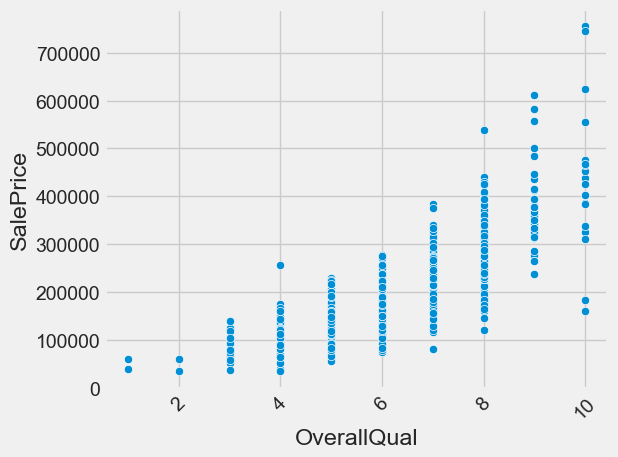

In [4]:
target = 'SalePrice'
var = 'OverallQual'

sns.scatterplot(data=df, x=var, y=target).tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('media/fig1.png')

Let's look at the `OverallQual` feature, to check if there is any relationship with `SalePrice` we use correlation (Pearson) to tell the direction of the relationship. The correlation shows 0.79 - a good sign with strong linear. However, we need a equation to capture this relationship.

## Univariate: y = α + βx + ε

In [5]:
def plot_linear_assumption(target, var, data):
    linear_model = smf.ols(f'{target} ~ {var}', data=data).fit()
    print(linear_model.summary().tables[1])
    print(f'{target} = {linear_model.params[0]:,.2f} + {linear_model.params[1]:,.2f} * {var}')
    print(f'R2: {linear_model.rsquared}')
    
    # stats to dataframe
    res = pd.DataFrame()
    res['Residuals'] = linear_model.resid
    res['Fitted_values'] = linear_model.fittedvalues
    res['Sqrt(Residuals_std)'] = linear_model.resid_pearson
    res['Leverage'] =  linear_model.get_influence().hat_matrix_diag
    
    # plot
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    line_kws = {'color': 'red', 'alpha': 0.8}
    
    # 4 assumptions
    sns.regplot(data=res, x='Fitted_values', y='Residuals', scatter=True, lowess=True, line_kws=line_kws, ax=axes[0]).set_title('Residuals vs Fitted')
    sm.qqplot(res['Residuals'], line='s', ax=axes[1])
    axes[1].set_title('Normal Q-Q')
    sns.regplot(data=res, x='Fitted_values', y='Sqrt(Residuals_std)', scatter=True, lowess=True, line_kws=line_kws, ax=axes[2]).set_title('Scale-Location')
    sns.regplot(data=res, x='Leverage', y='Sqrt(Residuals_std)', scatter=True, lowess=True, line_kws=line_kws, ax=axes[3]).set_title('Residuals vs Leverage')
    fig.tight_layout()
    
    # save plot
    plt.tight_layout()
    plt.savefig('media/fig2.png')

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -9.621e+04   5756.407    -16.713      0.000   -1.07e+05   -8.49e+04
OverallQual  4.544e+04    920.430     49.364      0.000    4.36e+04    4.72e+04
SalePrice = -96,206.08 + 45,435.80 * OverallQual
R2: 0.6256518924621182


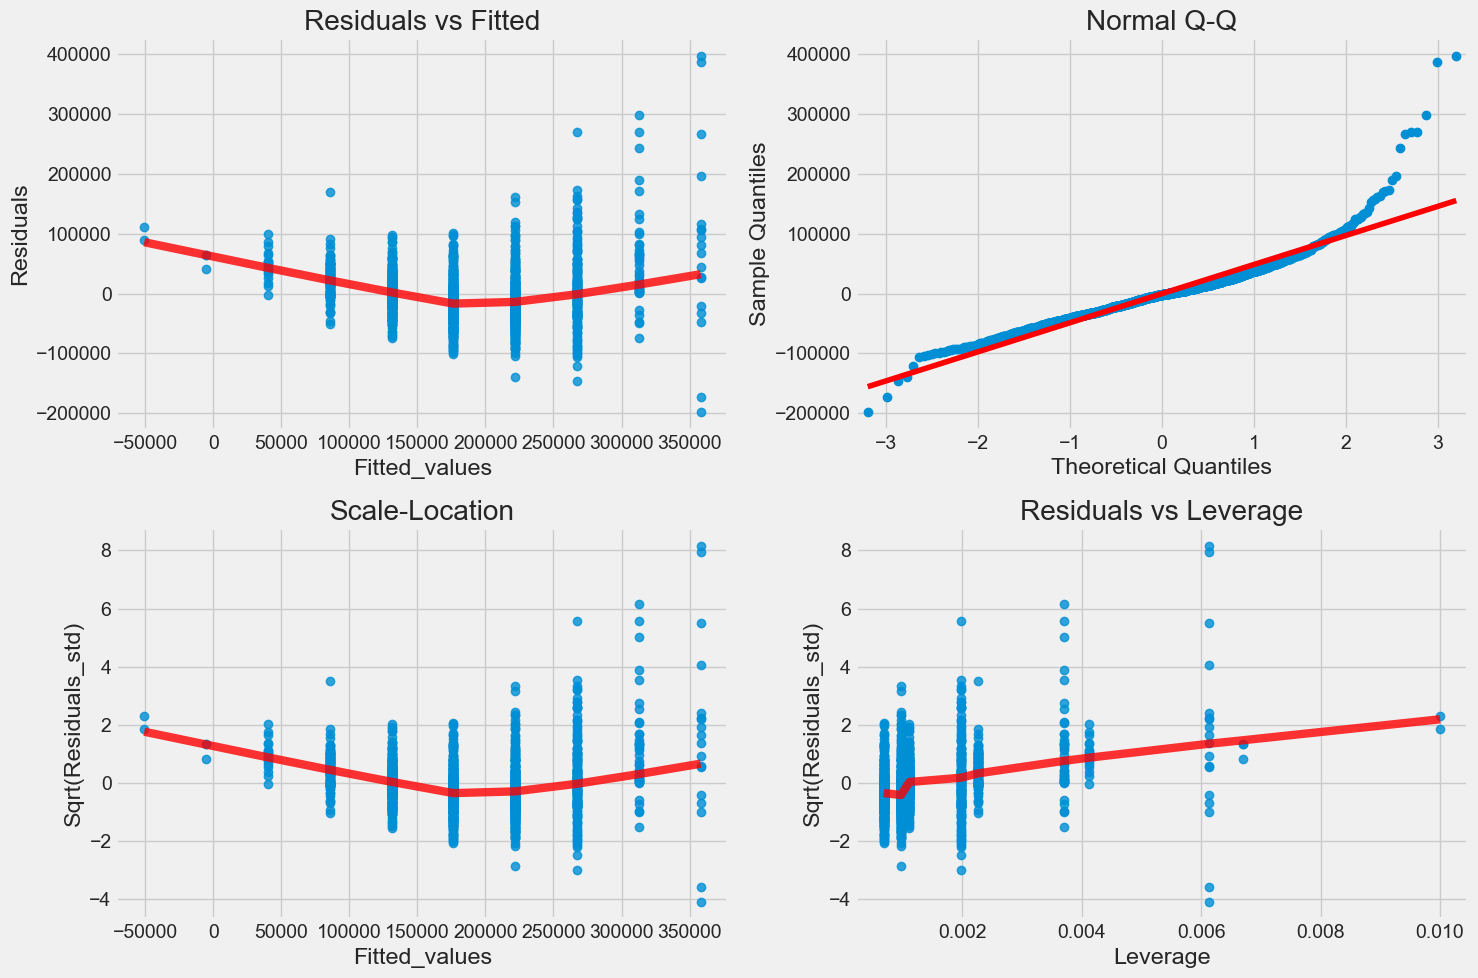

In [6]:
target = 'SalePrice'
var = 'OverallQual'
plot_linear_assumption(target, var, df)

<u>** Interpretation:</u>
- Slope: β = 45,435 means that when `OverallQual` increases in 1 points `SalePrice` will increase 45,435
- R2 = 62.5% means that `SalePrice` is explained 62.5% by `OverallQual`.

<u>** Checking Linear Assumptions:</u>
- 1st: `OverallQual` and `SalePrice` should have a linear relationship. The **Residuals vs Fitted** plot shows if there are any nonlinear patterns in the residuals. If this assumption holds and our data can be fit by a linear model, then we should see a relatively flat line when looking at the residuals vs fitted. Notice the bow-shaped line in red, this is an indicator that we are failing to capture some of the non-linear features of the model.
- 2nd: **The distribution of ε must be normally distributed**. The Normal QQ plot shows if the residuals are normally distributed. A good normal QQ plot has all of the residuals lying on or close to the red line. Looking at the graph above, there are several points that fall far away from the red line. This is indicative of the errors not being normally distributed, in fact our model suffers from “heavy tails”.
- 3rd: The Scale-Location shows if there are any relationships between standardized residuals and fitted values.
- 4th: This chart shows if there are any influential observation. The threshold is from -2 to 2.

## Univariate: Category

Let's take a look at a categorical variable `GarageType` to see how this variable affects to `SalePrice`

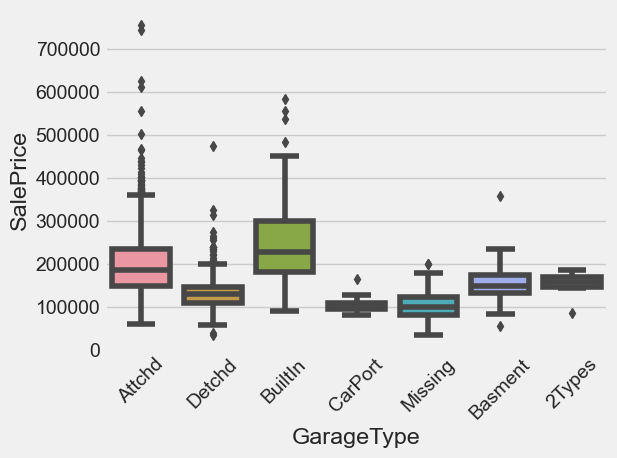

In [7]:
var = 'GarageType'
df[var].fillna('Missing', inplace=True)

sns.boxplot(data=df, x=var, y=target).tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('media/fig3.png')

It seems that that houses have BuiltIn `GarageType` have the higher `SalePrice` than others. To measure the difference, we run an OLS model to validate this hypothesis.

In [8]:
# coef
linear_model = smf.ols(f'{target} ~ {var}', data=df).fit()
print(linear_model.summary().tables[1])
print(f'R2: {linear_model.rsquared}')

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.513e+05   2.82e+04      5.372      0.000     9.6e+04    2.07e+05
GarageType[T.Attchd]   5.161e+04   2.83e+04      1.826      0.068   -3819.477    1.07e+05
GarageType[T.Basment]  9287.3509   3.23e+04      0.288      0.774   -5.41e+04    7.27e+04
GarageType[T.BuiltIn]  1.035e+05   2.91e+04      3.555      0.000    4.64e+04    1.61e+05
GarageType[T.CarPort] -4.132e+04   3.64e+04     -1.137      0.256   -1.13e+05       3e+04
GarageType[T.Detchd]  -1.719e+04   2.84e+04     -0.606      0.545   -7.29e+04    3.85e+04
GarageType[T.Missing] -4.797e+04   2.92e+04     -1.644      0.100   -1.05e+05    9281.930
R2: 0.24920423050428964


Based on P < 0.05, the result shows that houses built in BuiltIn have higher `SalePrice` than 2Types ~ 103,500. The result above only compares the price difference between 2Types and others. If we need to deep dive further, we use Tukey method to compare among `GarageType` to check others garage types.

In [9]:
mc = MultiComparison(df[target], df[var])
result = mc.tukeyhsd()
df_result = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])
df_result.sort_values('p-adj')

,group1,group2,meandiff,p-adj,lower,upper,reject
10,Attchd,Missing,-99575.3724,0.0000,-123233.5860,-75917.1588,True
17,BuiltIn,Missing,-151434.4547,0.0000,-182792.8140,-120076.0954,True
16,BuiltIn,Detchd,-120660.5758,0.0000,-144712.1669,-96608.9848,True
15,BuiltIn,CarPort,-144789.6275,0.0000,-216061.3249,-73517.9302,True
11,Basment,BuiltIn,94181.0544,0.0000,42662.0363,145700.0726,True
9,Attchd,Detchd,-68801.4935,0.0000,-81245.1025,-56357.8846,True
7,Attchd,BuiltIn,51859.0823,0.0000,29077.9337,74640.2310,True
8,Attchd,CarPort,-92930.5452,0.0012,-161165.5745,-24695.5160,True
20,Detchd,Missing,-30773.8788,0.0050,-55657.7968,-5889.9609,True
2,2Types,BuiltIn,103468.4053,0.0071,17539.2009,189397.6098,True


## Univariate: Non-Linear Relationships

Consider in particular the relationship between `OverallQual` and `SalePrice`. It might be a highly non-linear relationship.

`SalePrice` ~ β0 + β1*`OverallQual` + β2*`OverallQual`^2 + ...

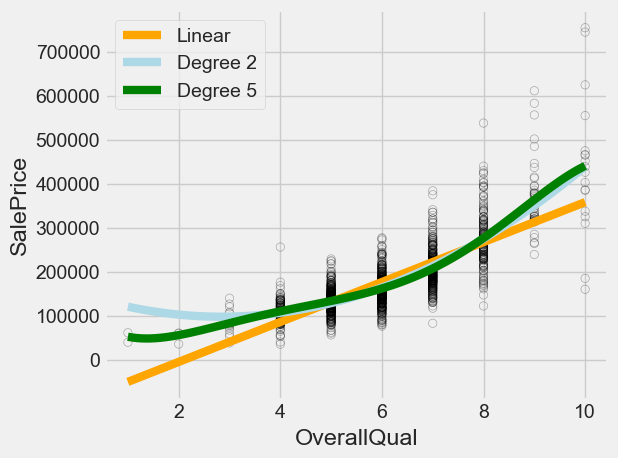

In [10]:
var = 'OverallQual'

fig, ax = plt.subplots(1, 1)

plt.scatter(x=df[var], y=df[target], facecolors='None', edgecolors='k', alpha=.3) 
sns.regplot(x=df[var], y=df[target], ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(x=df[var], y=df[target], ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(x=df[var], y=df[target], ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.tight_layout()
plt.savefig('media/fig4.png')

In [11]:
est = sm.OLS.from_formula('SalePrice ~ OverallQual', df).fit()
print(f'{target} = {est.params[0]:,.2f} + {est.params[1]:,.2f} * {var}')
print(f'R2: {est.rsquared}')
est.summary().tables[1]

SalePrice = -96,206.08 + 45,435.80 * OverallQual
R2: 0.6256518924621182


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-9.621e+04,5756.407,-16.713,0.000,-1.07e+05,-8.49e+04
OverallQual,4.544e+04,920.430,49.364,0.000,4.36e+04,4.72e+04


In [12]:
df['OverallQual2'] = df[var] ** 2
est = sm.OLS.from_formula(f'{target} ~ {var} + OverallQual2', df).fit()
print(f'{target} = {est.params[0]:,.2f} + {est.params[1]:,.2f} * {var} + {est.params[2]:,.2f} * OverallQual2')
print(f'R2: {est.rsquared}')
est.summary().tables[1]

SalePrice = 151,603.83 + -38,006.48 * OverallQual + 6,676.32 * OverallQual2
R2: 0.6784507354727529


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.516e+05,1.69e+04,8.978,0.000,1.18e+05,1.85e+05
OverallQual,-3.801e+04,5461.783,-6.959,0.000,-4.87e+04,-2.73e+04
OverallQual2,6676.3161,431.637,15.467,0.000,5829.620,7523.012


The Quadratic model has R2 0.67 > 0.62 baseline model

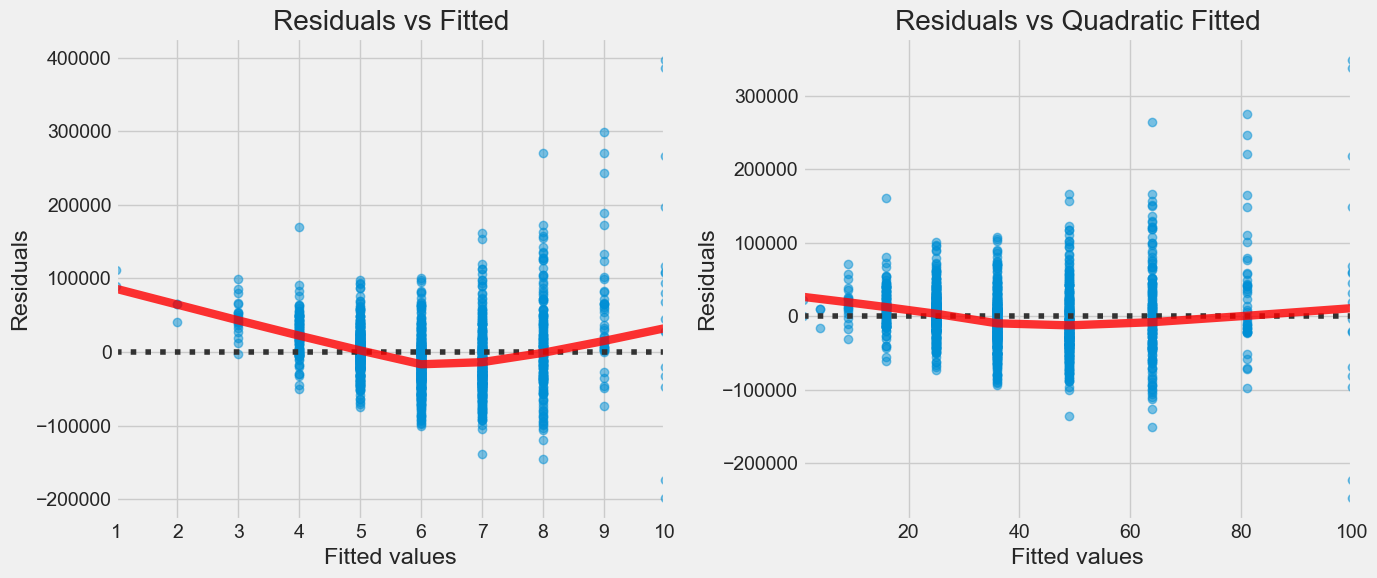

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()
line_kws = {'color': 'red', 'alpha': 0.8}

sns.residplot(data=df, x='OverallQual', y=target, lowess=True, scatter_kws={'alpha': 0.5}, line_kws=line_kws, ax=axes[0]).set_title('Residuals vs Fitted')
sns.residplot(data=df, x='OverallQual2', y=target, lowess=True, scatter_kws={'alpha': 0.5}, line_kws=line_kws, ax=axes[1]).set_title('Residuals vs Quadratic Fitted')
for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
fig.tight_layout()
plt.tight_layout()
plt.savefig('media/fig5.png')

This suggests a quadratic fit, the residuals `OverallQual2` seem more uniformly centered around zero.

## Multivariate
The application of Linear Regression for multivariate is for 3 main purposes: evaluate the relationship, control outliers and predict.

The basic idea of hedonic price modeling is that neighborhood-specific and unit-specific characteristics help determine house prices. If target variable is the `SalePrice`, then naturally the larger the house the higher the price, all else being equal. So property size measures will be key variables.

Any home buyer would have heard of the expression 'location, location, location', so one would expect neighborhood 'location' and associated characteristics, such as access to amenities (e.g. good schools, leisure facilities), transport networks (e.g. near a metro station), neighborhood aesthetics (e.g. tree-lined streets, handsome houses), and socioeconomic prestige among others, to have an impact on house prices.

The factors that effect housing prices may be summarized as property size, location desirability, nearby amenities, number of rooms, construction materials, and age and condition of the structure.

**Let's looking at size metrics**

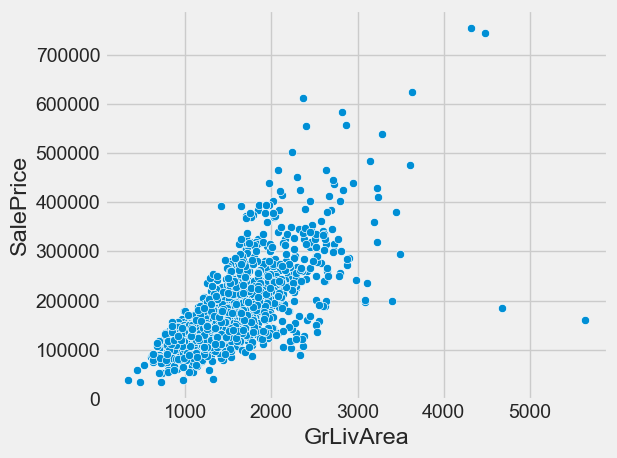

In [14]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice')
plt.tight_layout()
plt.savefig('media/fig6.png')

### Model 1: GrLivArea
`SalePrice` ~ β0 + β1*`GrLivArea` + ε

In [15]:
def run_model(feature_var, target_var, data):
    text_query = ' + '.join(feature_var)
    estimate = sm.OLS.from_formula(f'{target_var} ~ {text_query}', data).fit()
    rmse_score = rmse(data[target], estimate.predict(data[var]))
    mse_score = mse(data[target], estimate.predict(data[var]))
    print(f'R2: {estimate.rsquared:,.3f} \nMSE: {mse_score:,.0f}, RMSE: {rmse_score:,.0f}')
    print(estimate.summary().tables[1])

In [16]:
var = ['GrLivArea']
run_model(var, target, df)

R2: 0.502 
MSE: 3,139,843,210, RMSE: 56,034
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.857e+04   4480.755      4.144      0.000    9779.612    2.74e+04
GrLivArea    107.1304      2.794     38.348      0.000     101.650     112.610


With the model, we can see that on average, an increase of 1 unit in `GrLivArea` will make `SalePrice` increase to 107. The P < 0.05 states a result has statistical significance.

### Model 2: GrLivArea + GarageArea
`SalePrice` ~ β0 + β1*`GrLivArea` + β2*`GarageArea` + ε

In [17]:
var = ['GrLivArea', 'GarageArea']
run_model(var, target, df)

R2: 0.611 
MSE: 2,454,764,806, RMSE: 49,546
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6915.3807   4159.871     -1.662      0.097   -1.51e+04    1244.594
GrLivArea     80.6713      2.798     28.834      0.000      75.183      86.159
GarageArea   138.6572      6.876     20.165      0.000     125.169     152.146


`SalePrice` = -6915 + 80*`GrLivArea` + 138*`GarageArea` + ε

It means that `SalePrice` will increase 138 if we have `GarageArea` increase in 1 unit, other variables remaining constant. Both features has statistical significance.

Model 2 explain `SalePrice` better than Model 1, R2=61% comparing to R2=50%, RMSE decrease from 56034 to 49545

### Model 3: GrLivArea + LotConfig
`SalePrice` ~ β0 + β1*`GrLivArea` + β2*`LotConfig` + ε

In [18]:
var = ['GrLivArea', 'LotConfig']
run_model(var, target, df)

R2: 0.511 
MSE: 3,081,496,838, RMSE: 55,511
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.255e+04   5599.426      2.241      0.025    1567.196    2.35e+04
LotConfig[T.CulDSac]  3.373e+04   6688.183      5.043      0.000    2.06e+04    4.68e+04
LotConfig[T.FR2]      1.301e+04   8819.888      1.475      0.140   -4292.833    3.03e+04
LotConfig[T.FR3]      3.214e+04    2.8e+04      1.147      0.252   -2.28e+04    8.71e+04
LotConfig[T.Inside]   5979.3319   3845.032      1.555      0.120   -1563.071    1.35e+04
GrLivArea              106.4912      2.788     38.201      0.000     101.023     111.960


Let's look at model 3. Comparing to model 1, R2 and RSME do not change pretty much. The `LotConfig` does not affect much to the `SalePrice` as P-value show no statistical significance. The result can be interpreted that if 2 houses have same `GrLivArea`, `SalePrice` may be different because of randomness. Therefore, we can remove `LotConfig` feature.

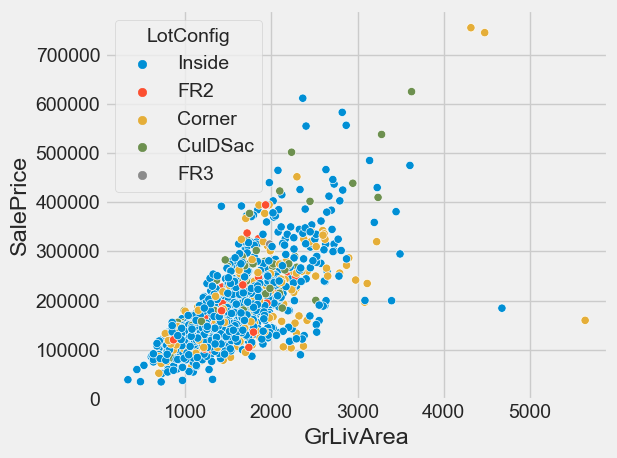

In [19]:
sns.scatterplot(data=df, x='GrLivArea', y='SalePrice', hue='LotConfig')
plt.tight_layout()
plt.savefig('media/fig7.png')

### Could we say a feature with higher coefficient is better than lower one?

Of course no and the reason is the coefficient of feature X attached to the unit of feature X. For examples, SalePrice = -6915 + 80*GrLivArea + 138*GarageArea + ε does not mean the coefficient of GarageArea (135) explains better than the coefficient of GrLivArea (80) because it depends on the unit of each feature.